# Initial Data Analysis for Thrombin Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdDeprotect
from rdkit.Chem.rdDeprotect import DeprotectData
import os
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

In [2]:
import sys
sys.path.append('/Users/aakankschitnandkeolyar/Desktop/PRISMS')  # Adjust the path to point to the project root directory
from PRISMS.library_enumeration.generate_products import *
from PRISMS.library_enumeration.enumeration_utils import *

## Functions of Interest:


In [3]:
def check_substructure(mol_list, substructure_SMARTS):
	"""
	Check whether a SMARTS pattern of a substructure is present in a set of molecules and identify where the substructure is present and where it is not present.
	:param mol_list: A list of SMILES
	:param substructure_SMARTS: SMARTS pattern for recognizing a specific substructure
	:return: selected_mol_list: A list of SMILES of molecules containing the substructure.
	"""
	molecule_list = [Chem.MolFromSmiles(x) for x in mol_list]
	sub_structure = Chem.MolFromSmarts(substructure_SMARTS)
	selected_molecules_list = []
	unselected_molecules_list = []
	for molecule in molecule_list:
		if molecule.HasSubstructMatch(sub_structure):
			selected_molecules_list.append(Chem.MolToSmiles(molecule))
		else:
			unselected_molecules_list.append(Chem.MolToSmiles(molecule))
	return selected_molecules_list, unselected_molecules_list

In [4]:
def standardize_and_remove_duplicates(smiles_list):
    """
    Standardize SMILES patterns and remove duplicates from a list.
    :param smiles_list: A list of SMILE strings
    :return: A list of unique, standardized SMILE strings
    """
    standardized_smiles = set()
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            standardized_smiles.add(Chem.MolToSmiles(mol, canonical=True))
    return list(standardized_smiles)

In [5]:
def count_functional_groups(smiles):
    """
    Count the number of primary amines, secondary amines, and carboxylic acids in a SMILES string.
    :param smiles: A SMILES string
    :return: A dictionary with counts of primary amines, secondary amines, and carboxylic acids
    """
    primary_amine_smarts = "[NH2]"
    secondary_amine_smarts = "[NH1]"
    carboxylic_acid_smarts = "C(=O)[OH]"

    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return {"primary_amines": 0, "secondary_amines": 0, "carboxylic_acids": 0}

    primary_amine_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(primary_amine_smarts)))
    secondary_amine_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(secondary_amine_smarts)))
    carboxylic_acid_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(carboxylic_acid_smarts)))

    return {
        "primary_amines": primary_amine_count,
        "secondary_amines": secondary_amine_count,
        "carboxylic_acids": carboxylic_acid_count,
    }

In [6]:
def count_functional_group_occurrences(molecules, functional_group_smarts):
    """
    Check if a molecule contains a specific functional group and count the occurrences.

    Parameters:
    molecules (list): List of SMILES strings representing the molecules.
    functional_group_smarts (str): SMARTS pattern of the functional group to search for.

    Returns:
    DataFrame: A DataFrame with molecule SMILES and the count of functional group occurrences.
    """
    functional_group = Chem.MolFromSmarts(functional_group_smarts)
    data = []

    for smiles in molecules:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            matches = mol.GetSubstructMatches(functional_group)
            count = len(matches)
        else:
            count = 0
        data.append({'SMILES': smiles, 'Occurrences': count})

    df = pd.DataFrame(data)
    return df

In [27]:
def read_smi_file(file_path):
    """
    Read in the input files
    Used to read a .smi file with SMILES and reagent number columns.

    Parameters:
    file_path (str): Path to the .smi file.
    column_names (list): List of column names for the DataFrame.

    Returns:
    DataFrame: A DataFrame containing the data from the .smi file.
    list: A list of SMILES strings.

    """
    df = pd.read_csv(file_path, sep=' ', header=None, names=['SMILES', 'Reagent_No', "Rotatable Bonds"])
    smiles_list = df['SMILES'].tolist()
    return df, smiles_list

# Linear Amide Bond Selection
This is the first library for thrombin that contains 500,000 products.

## Deprotection and pre-processing of Amino Acid Building Blocks
Deprotection and standardization of the amino acid SMILES.

### Deprotection Classes
There are multiple protected groups present in this library. I want to establish deprotection classes for each of them so that they can be removed as need when enumerating the library. This functionality is provided by `rdkit`. It is more prudent to only do this if there are more than one set of reactants that possess these protected groups. I will a different function for each since it is easier to work with the library enumeration that way.

In [3]:
def fmoc_deprotect(mol):
    """
    Deprotects a molecule containing a Fmoc protecting group.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol): The molecule to deprotect.
    Returns:
    rdkit.Chem.rdchem.Mol: The deprotected molecule.
    """
    reaction_class = "amine"
    reaction_smarts = "[c]1[c][c]c2c([c]1)-c3[c][c][c][c]c3[C]2[C]O[C](=O)[#7X3;H0,H1:1][#6:2]>>[#7:1][#6:2]"
    abbreviation = "Fmoc"
    full_name = "Fluorenylmethyloxycarbonyl"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

In [4]:
# Define a custom deprotection reaction for tbc
def tbc_deprotect(mol):
    """
    Deprotect a molecule using the tert-butyloxycarbonyl (tBoc) protecting group.
    :param mol: A molecule object
    :return: A molecule object
    """
    reaction_class = "amine"
    reaction_smarts = "[#6:1][#7X3;H0,H1:2][C](=O)OC([C])([C])[C]>>[#6:1][#7:2]"
    abbreviation = "tbc"
    full_name = "tert-butyloxycarbonyl"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

In [5]:
# Define cutom deprotection for pbf
# I am not asserting the statement here since I have made sure that the classes are valid 
def pbf_deprotect(mol):
    """
    Deprotect a molecule using the pentamethyldihydrobenzofuran-5-sulfonyl (Pbf) protecting group.
    :param mol: A molecule object
    :return: A molecule object
    """
    reaction_class = "amine"
    reaction_smarts = "[#6:1](=N)[#7X3;H0,H1:2]S(=O)(=O)c1c(c2c(c(c1[C])[C])OC([C]2)([C])[C])[C]>>[#6:1](=N)[#7X3:2]"
    abbreviation = "pbf"
    full_name = "pentamethyldihydrobenzofuran-5-sulfonyl"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

In [6]:
# Define custom deptrotection for tpg
def tpg_deprotect(mol):
    """
    Deprotect a molecule using the trityl protecting group.
    :param mol: A molecule object
    :return: A molecule object
    """
    reaction_class = "amine"
    reaction_smarts = "[#6:1][#7X3;H0,H1:2]C(c1[c][c][c][c][c]1)(c2[c][c][c][c][c]2)c3[c][c][c][c][c]3>>[#6:1][#7:2][H]"
    abbreviation = "tpg"
    full_name = "trityl"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

In [7]:
# Define custom deptrotection for tb
def tb_deprotect(mol):
    """
    Deprotect a molecule using the tert-butyl protecting group.
    :param mol: A molecule object
    :return: A molecule object
    """
    reaction_class = "hydroxyl"
    reaction_smarts = "[#8:1]C([C])([C])[C]>>[#8:1]"
    abbreviation = "tb"
    full_name = "tert-Butyl"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

In [8]:
# Define Custom deprotection for act
def act_deprotect(mol):
    """
    Deprotect a molecule using the acetal protecting group.
    :param mol: A molecule object
    :return: A molecule object
    """
    reaction_class = "hydroxyl"
    reaction_smarts = "[C]C1([#8:1][#6:2][#6:3][#8:4]1)[C]>>[#8:1][#6:2][#6:3][#8:4]"
    abbreviation = "act"
    full_name = "acetal"

    deprotect_data = DeprotectData(reaction_class, reaction_smarts, abbreviation, full_name)
    deprotected_mol = rdDeprotect.Deprotect(mol, [deprotect_data])
    return deprotected_mol

### Amino acid Clean up
Lets start by deprotecting the amines that are protected by the Fmoc group since these are the reaction centers for peptide coupling.

In [12]:
# Load the Raw Data
amino_acids = []
with open('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/amino_acids.smi') as f:
    for mol in f:
        amino_acids.append(mol.strip())

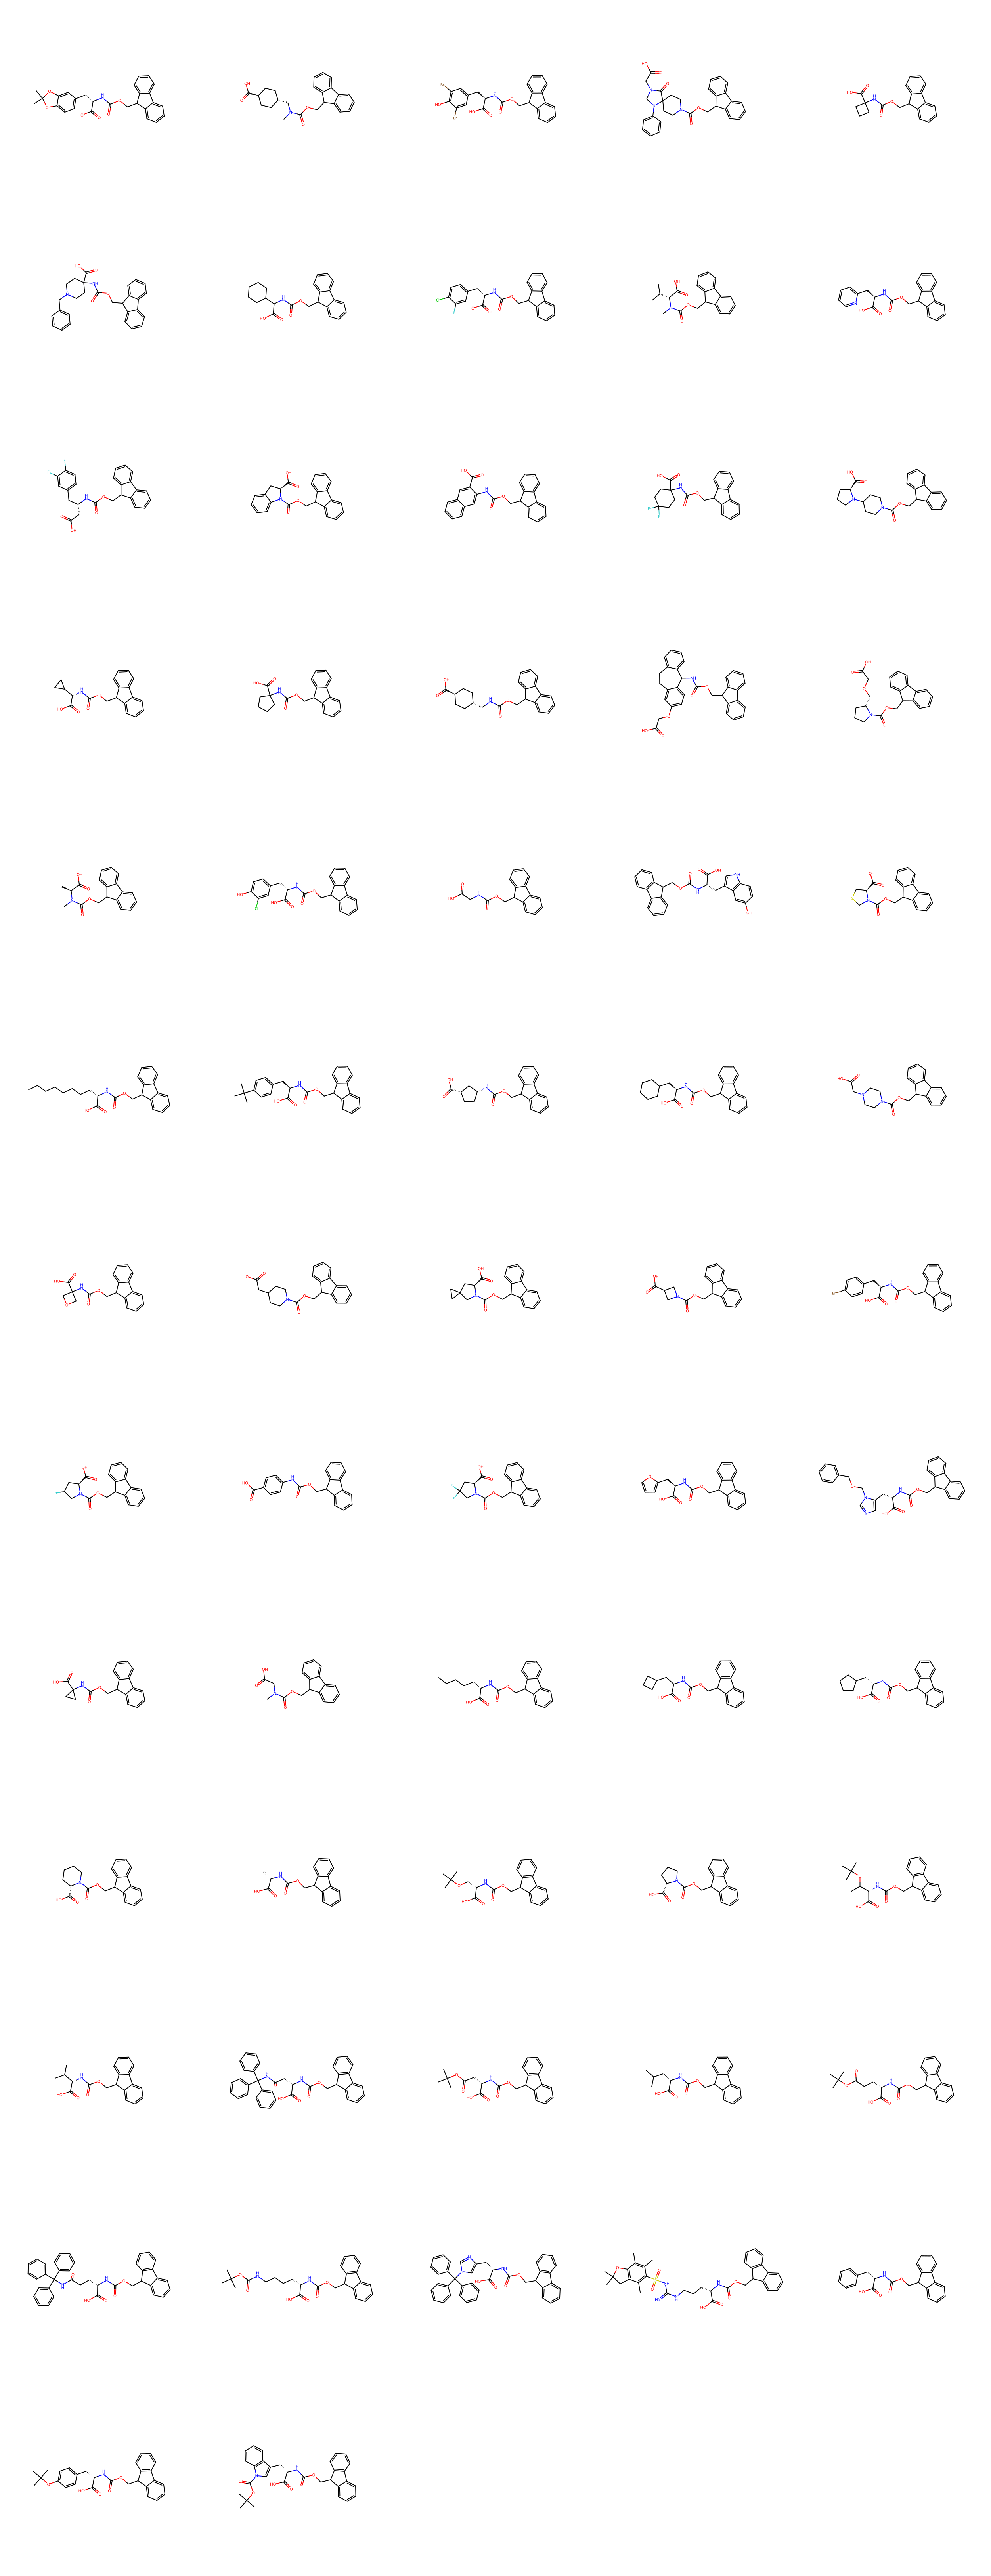

In [56]:
# Visualize the amino acids
amino_acid_list = [Chem.MolFromSmiles(smiles) for smiles in amino_acids]
Draw.MolsToGridImage(amino_acid_list, molsPerRow=5, subImgSize=(500, 500), maxMols=999999)

There are multiple protecting groups here. Please check notes for a complete list.
* We will start with deprotecting the Fmoc group since the amines that this group deprotects are the reaction center for the peptide coupling.

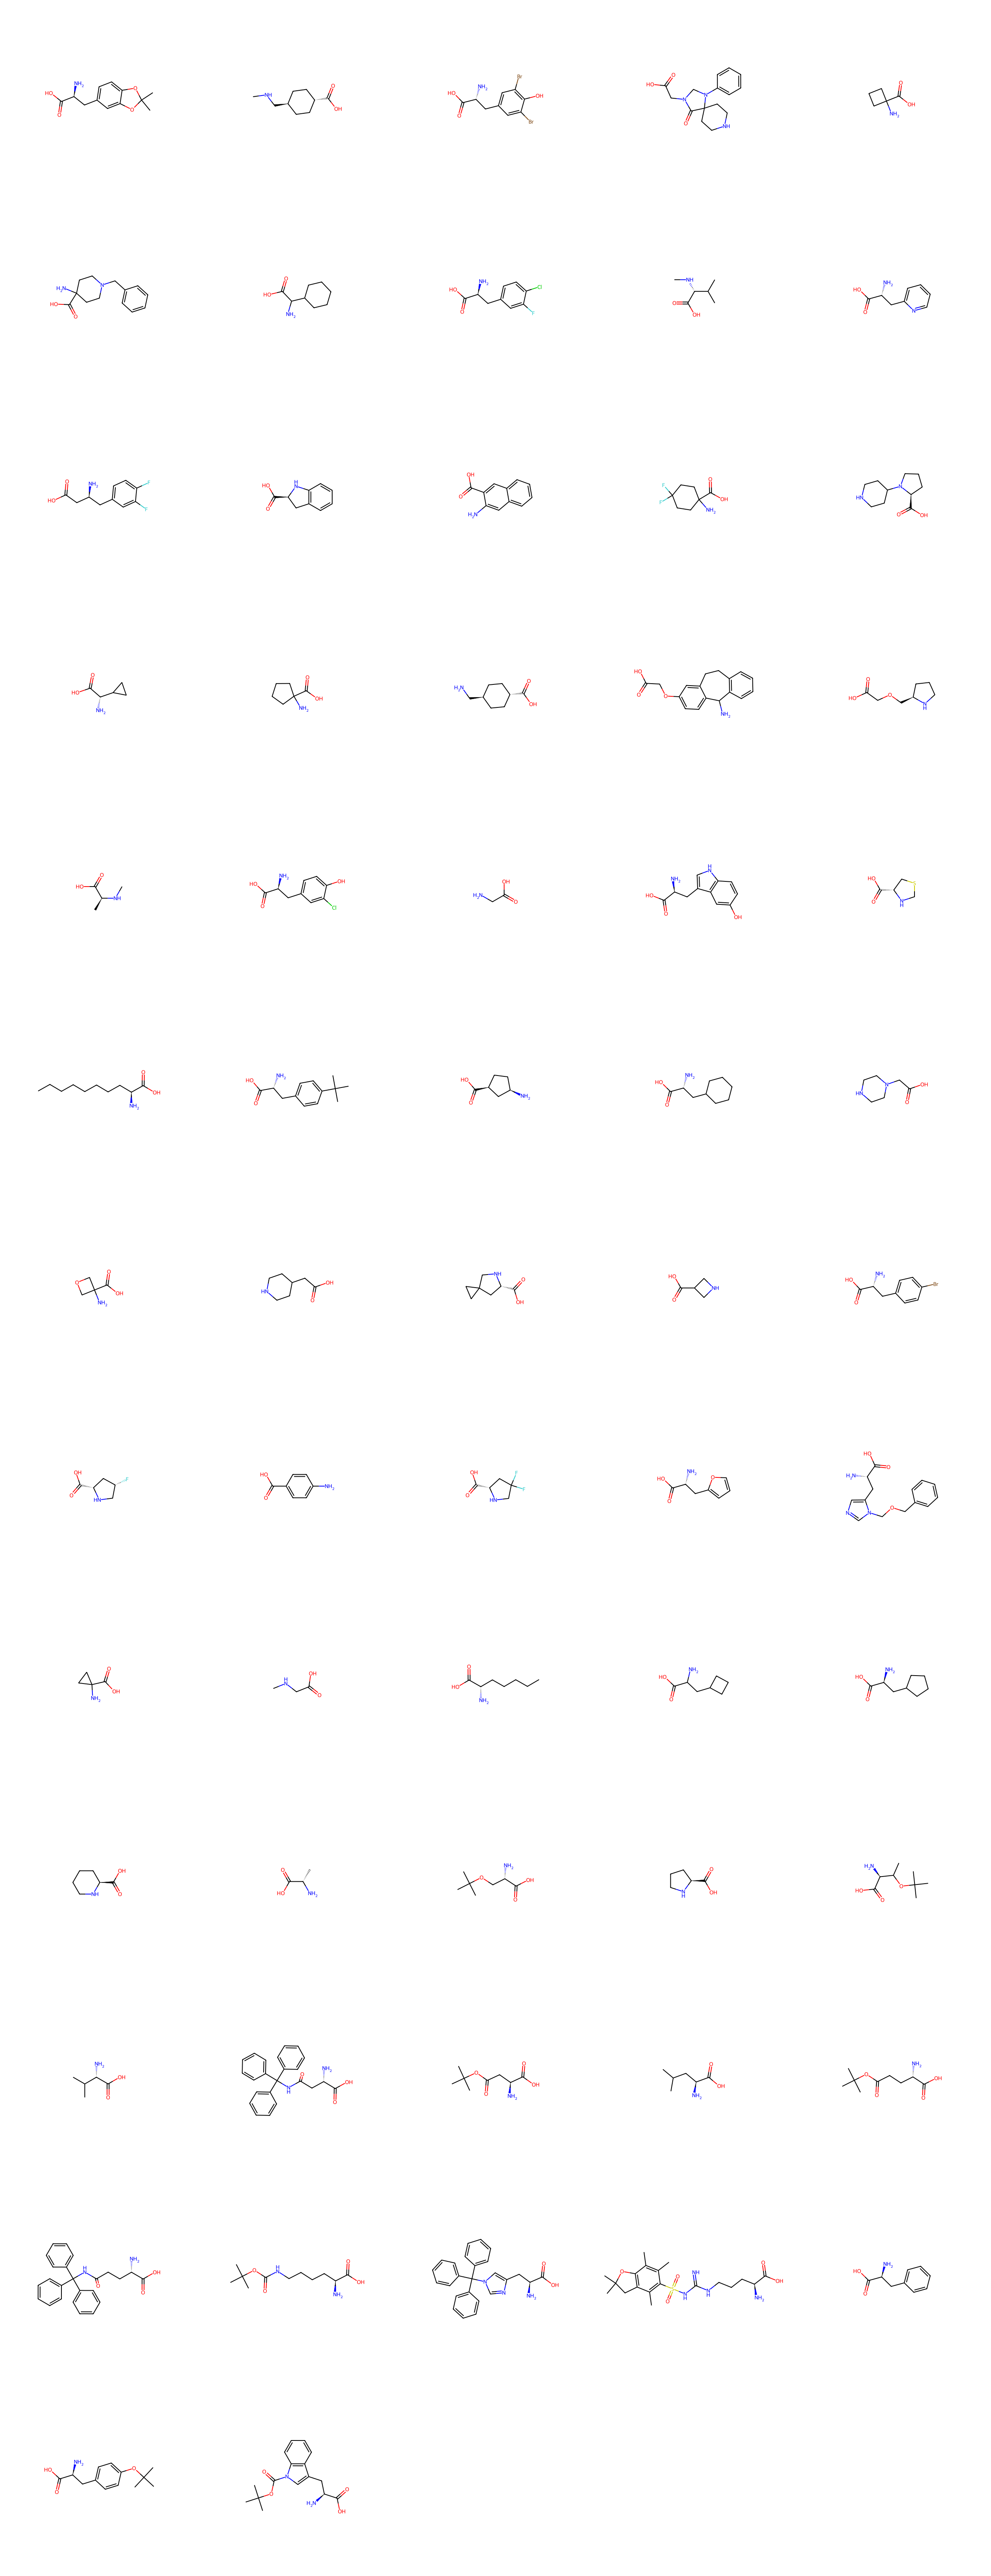

In [31]:
# Deprotect the amino acids
amino_acid_mols = [Chem.MolFromSmiles(x) for x in amino_acids]
amino_acid_no_Fmoc_mols = [fmoc_deprotect(x) for x in amino_acid_mols]
Draw.MolsToGridImage(amino_acid_no_Fmoc_mols, molsPerRow=5, subImgSize=(500, 500), maxMols=999999)

These structures look alright based on visual inspection, but it will be a good idea to get the medicinal chemist to take a look at it and confirm that these structures look alright.

### Write the Fmoc deprotected amino acids to a file
This file will be used to generate the coupled amino acids.

In [ ]:
# Convert Amino acid molecules to SMILES
# Standardize and remove duplicates SMILES
amino_acids_no_Fmoc = standardize_and_remove_duplicates([Chem.MolToSmiles(x) for x in amino_acid_no_Fmoc_mols])

In [38]:
with open('../Data/Thrombin/input_files/amino_acids_no_fmoc.smi', 'w') as w:
    for number,mol in enumerate(amino_acids_no_Fmoc):
            reagent_no = "AA"+str(number)
            w.write(f"{mol}")
            w.write(" ")
            w.write('%s' % reagent_no) # Name of the building block
            w.write(os.linesep)

In [ ]:
# Keep this block for refer
# Check for the presence of the FMOC and PBF protecting groups or the presence of both
amino_acids_no_FMOC = []
fmoc_substructure = Chem.MolFromSmarts('[c]1[c][c]c2c([c]1)-c3[c][c][c][c]c3[C]2[C]O[C]=O')
pbf_substructure = Chem.MolFromSmarts('[C][c]1[c]([c]([c]([c]2[c]1[O][C]([C]2)([C])[C])[C])S(=O)=O)[C]')
with open('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/amino_acids.smi') as f:
	for mol in f:
		molecule = Chem.MolFromSmiles(mol)
		if molecule.HasSubstructMatch(pbf_substructure) and not molecule.HasSubstructMatch(fmoc_substructure):
			mol_without_pbf = Chem.DeleteSubstructs(molecule, pbf_substructure)
			mol_no_pbf = Chem.MolToSmiles(mol_without_pbf)
			amino_acids_no_FMOC.append(mol_no_pbf)
		elif molecule.HasSubstructMatch(fmoc_substructure) and not molecule.HasSubstructMatch(pbf_substructure):
			mol_without_fmoc = Chem.DeleteSubstructs(molecule, fmoc_substructure)
			mol_no_fmoc = Chem.MolToSmiles(mol_without_fmoc)
			amino_acids_no_FMOC.append(mol_no_fmoc)
		elif molecule.HasSubstructMatch(pbf_substructure) and molecule.HasSubstructMatch(fmoc_substructure):
			mol_without_pbf = Chem.DeleteSubstructs(molecule, pbf_substructure)
			mol_without_fmoc = Chem.DeleteSubstructs(mol_without_pbf, fmoc_substructure)
			mol_no_fmoc = Chem.MolToSmiles(mol_without_fmoc)
			amino_acids_no_FMOC.append(mol_no_fmoc)
		else:
			amino_acids_no_FMOC.append(mol)
		

## Amino Acid Coupling
Here we wil couple the amino acids. We will utilize the enumeration module from the package for this.

In [3]:
# Lets enumerate the amino acids
# Load Data
df_amino_acids = get_bb_data(['../Data/Thrombin/input_files/amino_acids_no_fmoc.smi',
                              '../Data/Thrombin/input_files/amino_acids_no_fmoc.smi'])

In [ ]:
amino_acid_coupling = '[#6X3:1](=[#8X1])[OH].[#7X3;H1,H2;!$(N[!#6]);!$(N[#6]=[O]);!$(N[#6]~[!#6;!#16]):2]>>[#6X3:1](=[#8X1])[#7X3:2]'

In [13]:
amino_acid_coupling_df = combine_building_blocks(df_amino_acids, smarts=amino_acid_coupling)

Generated 3844 reactant combinations


100%|██████████| 3844/3844 [00:00<00:00, 14604080.23it/s]

Generated 3844 products
All reactants were used to generate products


#### Amino Acid Linker Substitution Reaction
Here we will substitute the hydroxyl of the carboxylic acid with a primary amine. This step is used by the experimentalists and hence is incorperated into the workflow. 

In [14]:
rxn_amine_linker = AllChem.ReactionFromSmarts("[#6:1](=O)[OH]>>[#6:1](=O)[NH2]")
# Run the substitution for each of the coupled amino acids
coupled_amino_acid_linker = []
for coupled_aa_prod in amino_acid_coupling_df['Product_SMILES']:
    mol = Chem.MolFromSmiles(coupled_aa_prod)
    prod_mol = rxn_amine_linker.RunReactants((mol,))[0][0]
    coupled_amino_acid_linker.append(Chem.MolToSmiles(prod_mol))

In [15]:
# Create a copy of the coupled amino acid dataframe
# Replace the 'Product_SMILES' column with the new amine substituted SMILES
amino_acids_coupling_sub_df = amino_acid_coupling_df.clone()
amino_acids_coupling_sub_df = amino_acids_coupling_sub_df.with_columns([pl.Series("Product_SMILES", coupled_amino_acid_linker)])

In [16]:
# Write to .smi files
write_products_to_files(amino_acids_coupling_sub_df, '../Data/Thrombin/input_files/')

Note: The write_products_to_files function will generate a file with the name "products_n.smi" for example where n can be the number of files. I have renamed the output for the above cell as `coupled_aa_sub.smi`.

## Carboxylic Acid Building Blocks processing
Deprotection and Stadardization of carboxylic acid building blocks.

In [138]:
acids = []
with open('../Data/Thrombin/acids.smi') as f:
    for mol in f:
        acids.append(mol.strip())

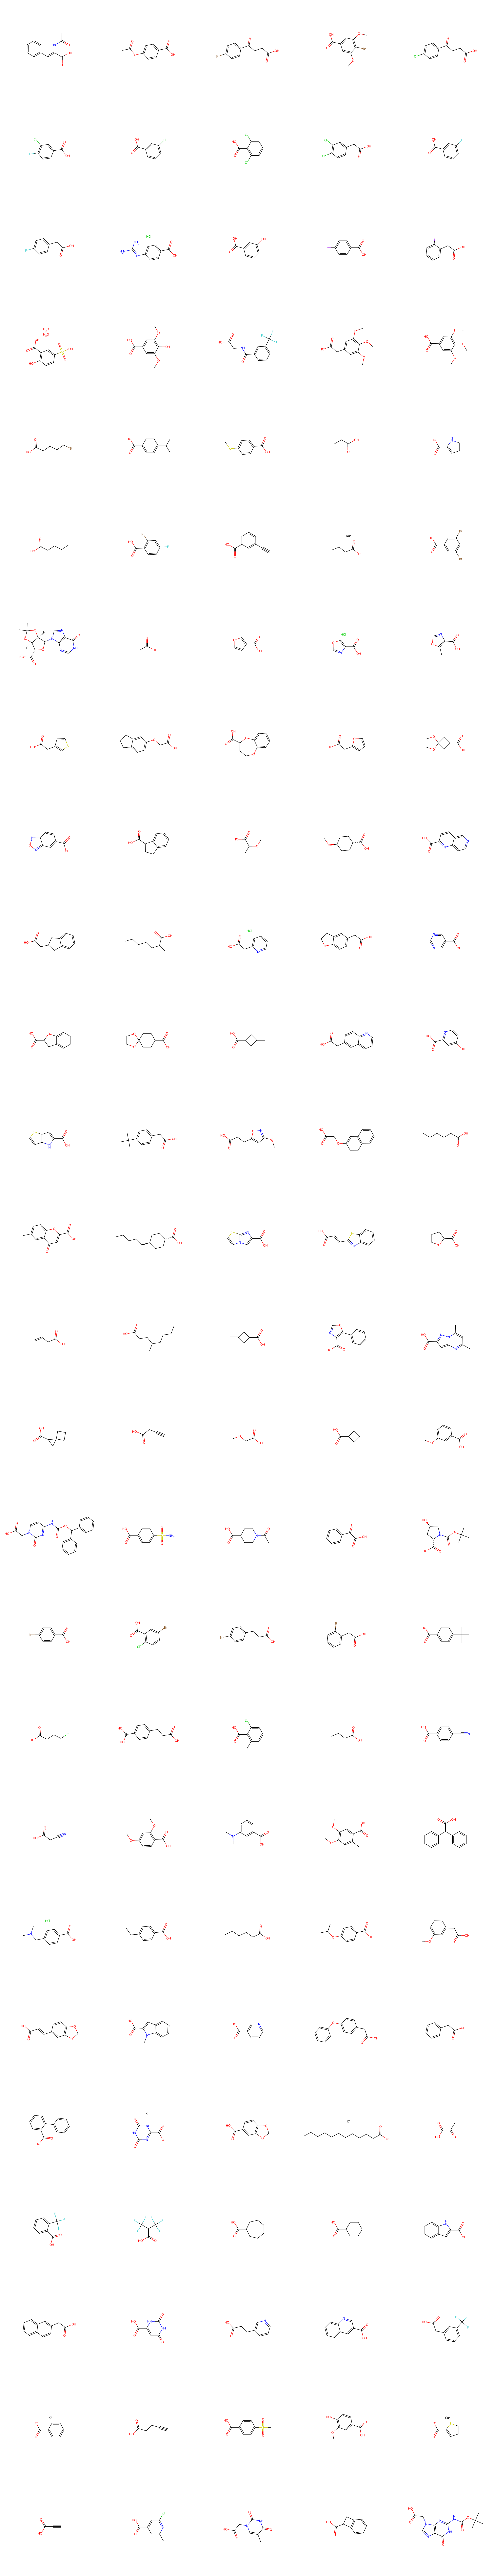

In [ ]:
# Visualize the acids
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in acids], molsPerRow=5, subImgSize=(500, 500), maxMols=999999)


In [17]:
# Check for duplicates and standardize the SMILES
acids = standardize_and_remove_duplicates(acids)

In [18]:
# Count the number of carboxylic acids for each molecule
carboxylic_acid_counts = count_functional_group_occurrences(acids, "[#6](=O)[OH]")


In [19]:
# There are some compounds with no carboxylic acids
acids_issues = carboxylic_acid_counts[(carboxylic_acid_counts["Occurrences"] != 1)]["SMILES"]
print(carboxylic_acid_counts[(carboxylic_acid_counts["Occurrences"] != 1)])

                                  SMILES  Occurrences
54                    CCCC(=O)[O-].[Na+]            0
63                O=C([O-])c1cccs1.[Cu+]            0
64                O=C([O-])c1ccccc1.[K+]            0
71  O=C([O-])c1nc(=O)[nH]c(=O)[nH]1.[K+]            0
85             CCCCCCCCCCCC(=O)[O-].[K+]            0


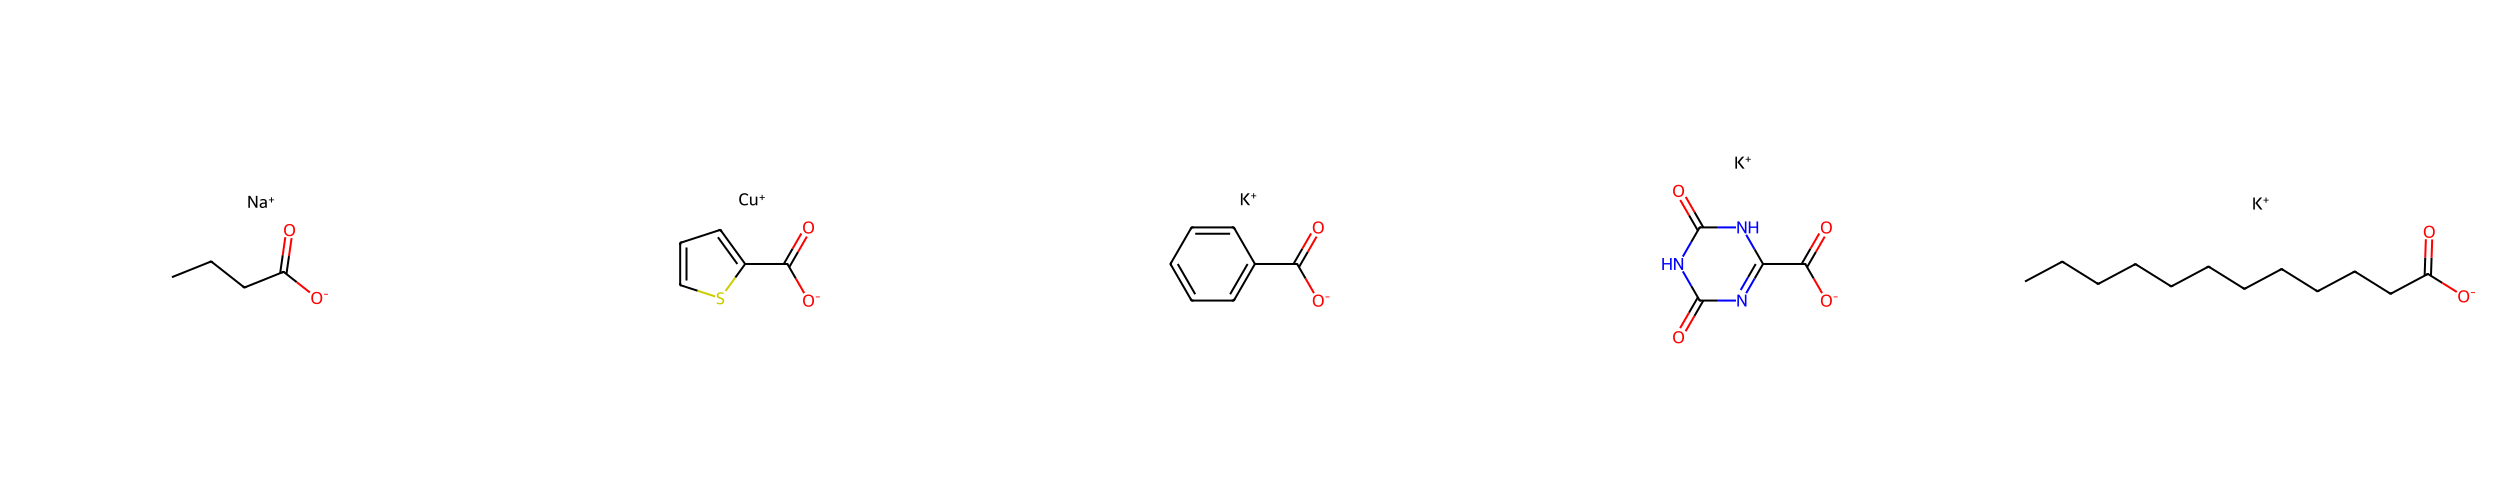

In [20]:
# Visualize acids with issues
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in acids_issues], molsPerRow=5, subImgSize=(500, 500), maxMols=999999)

In [23]:
with open('../Data/Thrombin/input_files/acids.smi', 'w') as w:
    for number,mol in enumerate(acids):
            reagent_no = "CA"+str(number)
            w.write(f"{mol}")
            w.write(" ")
            w.write('%s' % reagent_no) # Name of the building block
            w.write(os.linesep)

#### Note: Editing Carboxylic Acid files
The five acid molecules with cations had their SMILES edited in the file mentioned written above, this method was adopted since there were only five molecules whose SMILES needed editing.

## Linear Amide Bond Formation using a Carboxylic Acid

#### Load Input files that will be used to generate products
These files will need to be reformatted with names for each of the building blocks.

In [9]:
# Load modified carboxylic acids
acids_input = []
with open('../Data/Thrombin/input_files/acids.smi') as f:
    for line in f:
        smiles, reagent_no = line.strip().split()
        acids_input.append(smiles)

In [17]:
# Load Coupled Amino Acids
coupled_aa = []
with open('../Data/Thrombin/input_files/coupled_aa_sub.smi') as f:
    for line in f:
        smiles, reagent_no = line.strip().split()
        coupled_aa.append(smiles)

In [18]:
# Create lists of the acids and coupled amino acids
acid_mols = [Chem.MolFromSmiles(x) for x in acids_input]
coupled_aa_mols = [Chem.MolFromSmiles(x) for x in coupled_aa]

In [11]:
# Reductive amidation reaction with carboxylic acid
amidation = '[#6:1](=[O:2])[OH].[#7X3;H1,H2;!$(N[!#6]);!$(N[#6]=[O]);!$(N[#6]~[!#6;!#16]):3]>>[#6:1](=[O:2])[#7:3]'
amidation_rxn = AllChem.ReactionFromSmarts(amidation)

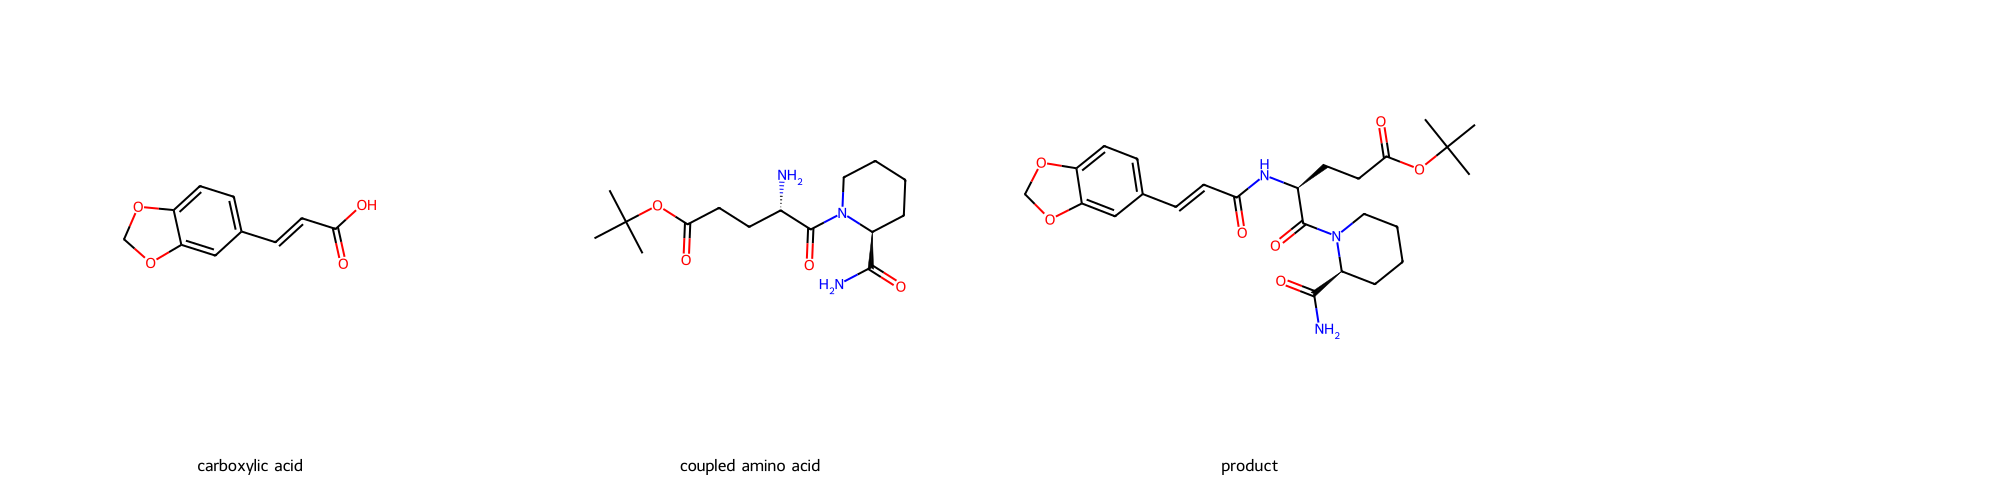

In [29]:
test_prod = amidation_rxn.RunReactants((acid_mols[20], coupled_aa_mols[3393]))[0][0]
Chem.Draw.MolsToGridImage([acid_mols[20], coupled_aa_mols[3393], test_prod],molsPerRow=4, subImgSize=(500, 500), legends=["carboxylic acid", "coupled amino acid", "product"])

It looks like the reaction SMARTS works appropriately at least in the cases that I tried. So I will go ahead and generate a set of product files to ensure that the entire library can be enumerated.

#### Enumerate Library 
Using the module as above we will enumerate the whole library and write the products to output files.

In [9]:
# Load Data
df_input_data = get_bb_data(['../Data/Thrombin/input_files/acids.smi',
                              '../Data/Thrombin/input_files/coupled_aa_sub.smi'])

In [12]:
enum_library = combine_building_blocks(df_input_data, smarts=amidation)

Generated 499720 reactant combinations


100%|██████████| 499720/499720 [00:00<00:00, 15411599.96it/s]


Generated 499720 products
All reactants were used to generate products


#### Need to remove all the protecting groups
There are still a few protecting groups on the products that we are working with these will need to be removed.

In [13]:
deprotected_prods = []
for prod_smiles in enum_library['Product_SMILES']:
    mol = Chem.MolFromSmiles(prod_smiles)
    # Check if it has a pbf protecting group
    if mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(=O)c1c(c2c(c(c1[C])[C])OC([C]2)([C])[C])[C]')):
        deprotected_mol = pbf_deprotect(mol)
        deprotected_prods.append(Chem.MolToSmiles(deprotected_mol))
    # Check if it has the tbc protecting group
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[#7][C](=O)OC([C])([C])[C]')):
        deprotected_mol = tbc_deprotect(mol)
        deprotected_prods.append(Chem.MolToSmiles(deprotected_mol))
    # Check if it has the tpg protecting group
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('C(c1[c][c][c][c][c]1)(c2[c][c][c][c][c]2)c3[c][c][c][c][c]3')):
        deprotected_mol = tpg_deprotect(mol)
        deprotected_prods.append(Chem.MolToSmiles(deprotected_mol))
    # Check if it has the tb protecting group
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[#8]C([C])([C])[C]')):
        deprotected_mol = tb_deprotect(mol)
        deprotected_prods.append(Chem.MolToSmiles(deprotected_mol))
    elif mol.HasSubstructMatch(Chem.MolFromSmarts('[C]C1([#8][#6][#6][#8]1)[C]')):
        deprotected_mol = act_deprotect(mol)
        deprotected_prods.append(Chem.MolToSmiles(deprotected_mol))
    else:
        deprotected_prods.append(Chem.MolToSmiles(mol))


In [14]:
enum_deprotect_df = enum_library.clone()
enum_deprotect_df = enum_deprotect_df.with_columns([pl.Series("Product_SMILES", deprotected_prods)])

In [15]:
# Write enumerated library to files
write_products_to_files(enum_deprotect_df, '/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/')